In [2]:
from google.colab import files
uploaded = files.upload()

Saving processed_zone_features.csv to processed_zone_features.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 1. Load data
df = pd.read_csv('processed_zone_features.csv')

# 2. Fill missing values with column medians
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. Convert numeric Risk to binary classes: High (>= median), Medium (< median)
threshold = df['Risk'].median()
df['Risk_Level'] = df['Risk'].apply(lambda x: 'High' if x >= threshold else 'Medium')

# 4. Select mining-relevant features
features = df[[
    'NO2_Differential',
    'Environmental_Stress',
    'WaterLevel_Mean',
    'DistanceToForest',
    'Water_Pollution_Interaction'
]]

# 5. Encode target
le = LabelEncoder()
target = le.fit_transform(df['Risk_Level'])  # High=1, Medium=0

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    stratify=target,
    random_state=42
)

# 7. Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Train Extra Trees Classifier
model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 9. Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 10. Save model artifacts
joblib.dump(model, 'mining_risk_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model saved successfully!")


Model Accuracy: 81.82%

Classification Report:
              precision    recall  f1-score   support

        High       0.83      0.83      0.83         6
      Medium       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11

Model saved successfully!


In [4]:
'''from google.colab import files
files.download('mining_risk_model.pkl')
files.download('feature_scaler.pkl')
files.download('label_encoder.pkl')'''


"from google.colab import files\nfiles.download('mining_risk_model.pkl')\nfiles.download('feature_scaler.pkl')\nfiles.download('label_encoder.pkl')"

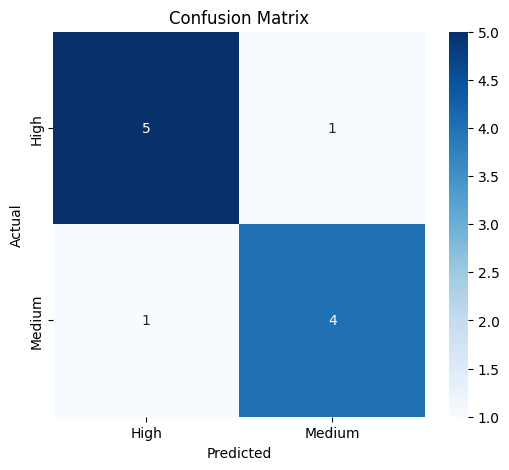

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


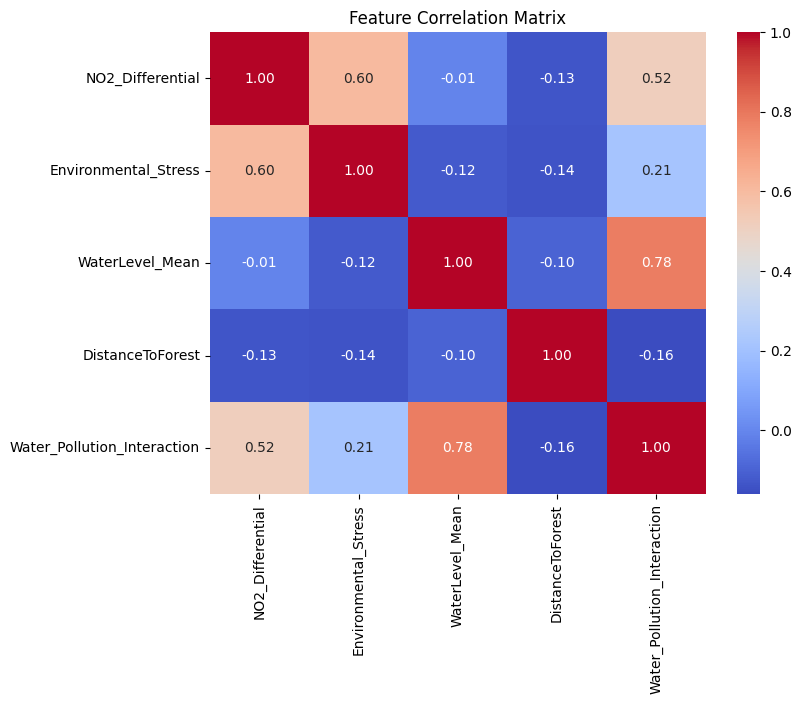

In [6]:
plt.figure(figsize=(8, 6))
corr = features.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        High       0.83      0.83      0.83         6
      Medium       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



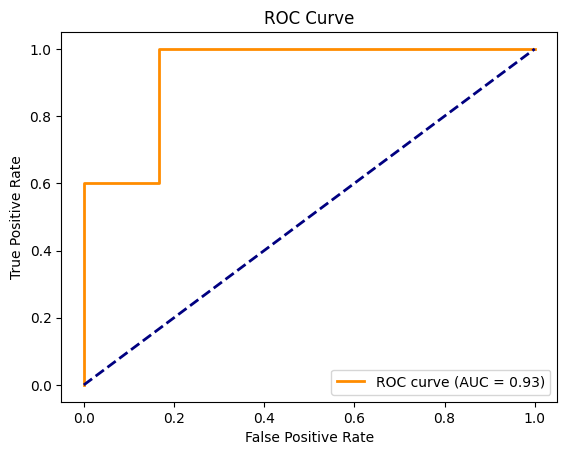

In [8]:
from sklearn.metrics import roc_curve, auc

if len(le.classes_) == 2:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [9]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import r2_score

# Assuming you have y_test (actual) and y_pred (predicted)
fig = px.scatter(
    x=y_test,
    y=y_pred,
    labels={'x': 'Actual Values', 'y': 'Predicted Values'},
    title='Actual vs. Predicted Values',
    trendline='ols',  # Adds regression line
    trendline_color_override='red'
)


# Diagonal reference line
fig.add_shape(
    type="line",
    line=dict(dash='dash', color='black'),
    x0=min(y_test), y0=min(y_test),
    x1=max(y_test), y1=max(y_test)
)

fig.update_layout(
    width=800,
    height=600,
    showlegend=False
)
fig.show()


In [10]:
from sklearn.model_selection import cross_val_predict
import numpy as np

# Define X_all and y_all using the original features and target
X_all = features # features was defined in cell GbofeLHbyqSI
y_all = target # target was defined in cell GbofeLHbyqSI

# Generate predictions using k-fold cross-validation
# Scale X_all before making predictions
X_all_scaled = scaler.transform(X_all) # scaler was defined and fitted in cell GbofeLHbyqSI
y_pred_cv = cross_val_predict(model, X_all_scaled, y_all, cv=5)  # Use 5-10 folds

<Figure size 1000x600 with 0 Axes>

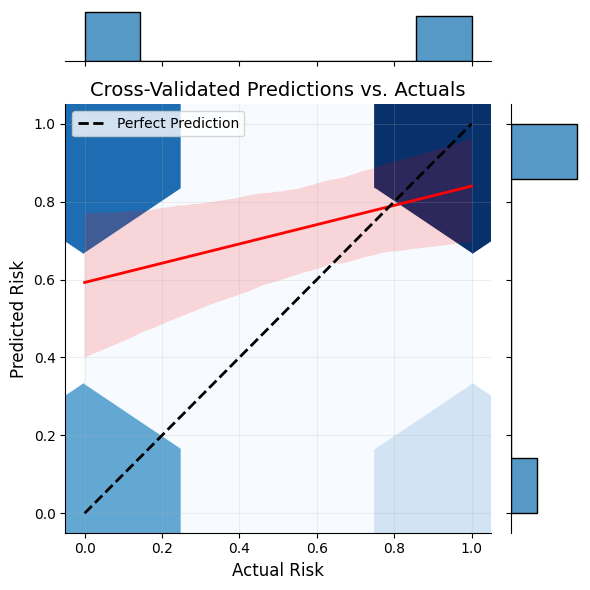

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

plt.figure(figsize=(10, 6))

# 1. Scatter plot with density estimation
sns.jointplot(
    x=y_all,
    y=y_pred_cv,
    kind='hex',  # Shows density where points cluster
    cmap='Blues',
    marginal_kws={'color': '#1f77b4'}
)

# 2. Regression line
sns.regplot(
    x=y_all,
    y=y_pred_cv,
    scatter=False,
    line_kws={'color': 'red', 'lw': 2, 'label': 'Regression Line'}
)

# 3. Perfect prediction line (y=x)
min_val = min(y_all.min(), y_pred_cv.min())
max_val = max(y_all.max(), y_pred_cv.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')


plt.xlabel('Actual Risk', fontsize=12)
plt.ylabel('Predicted Risk', fontsize=12)
plt.title('Cross-Validated Predictions vs. Actuals', fontsize=14)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


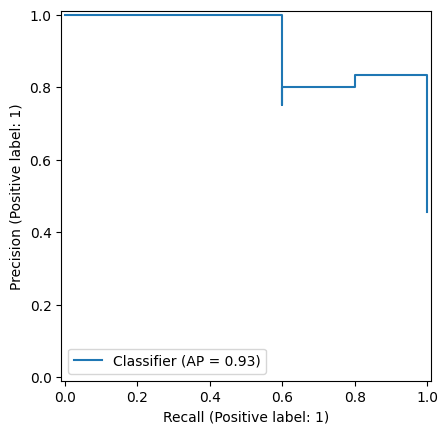

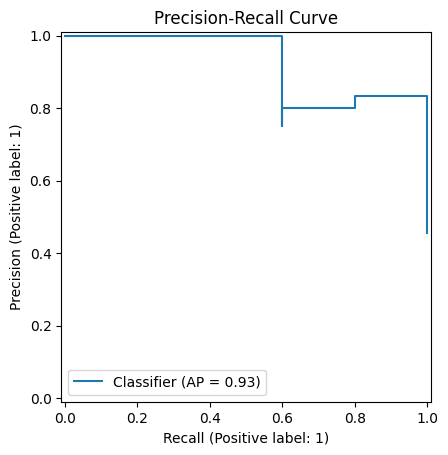

In [12]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

# Re-define necessary variables from the previous code block
df = pd.read_csv('processed_zone_features.csv')
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
threshold = df['Risk'].median()
df['Risk_Level'] = df['Risk'].apply(lambda x: 'High' if x >= threshold else 'Medium')
features = df[[
    'NO2_Differential',
    'Environmental_Stress',
    'WaterLevel_Mean',
    'DistanceToForest',
    'Water_Pollution_Interaction'
]]
le = LabelEncoder()
target = le.fit_transform(df['Risk_Level'])
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    stratify=target,
    random_state=42
)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)
y_proba = model.predict_proba(X_test_scaled)


# For binary classification
PrecisionRecallDisplay.from_predictions(y_test, y_proba[:, 1]).plot()
plt.title("Precision-Recall Curve")
plt.show()

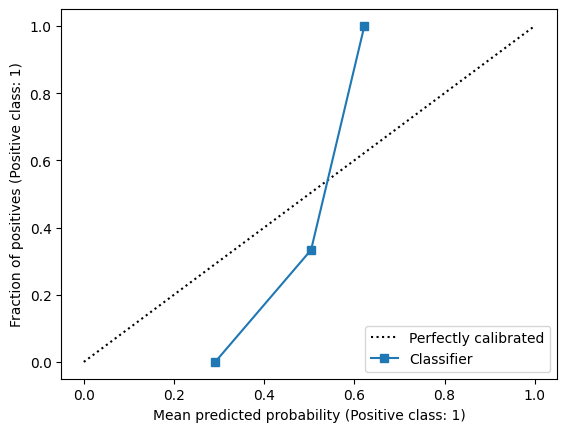

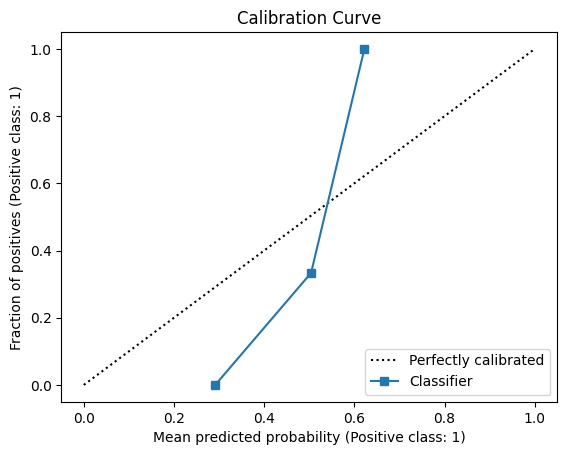

In [13]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

# Re-define necessary variables from the previous code block
df = pd.read_csv('processed_zone_features.csv')
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
threshold = df['Risk'].median()
df['Risk_Level'] = df['Risk'].apply(lambda x: 'High' if x >= threshold else 'Medium')
features = df[[
    'NO2_Differential',
    'Environmental_Stress',
    'WaterLevel_Mean',
    'DistanceToForest',
    'Water_Pollution_Interaction'
]]
le = LabelEncoder()
target = le.fit_transform(df['Risk_Level'])
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    stratify=target,
    random_state=42
)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)
y_proba = model.predict_proba(X_test_scaled)

CalibrationDisplay.from_predictions(y_test, y_proba[:, 1]).plot()
plt.title("Calibration Curve")
plt.show()

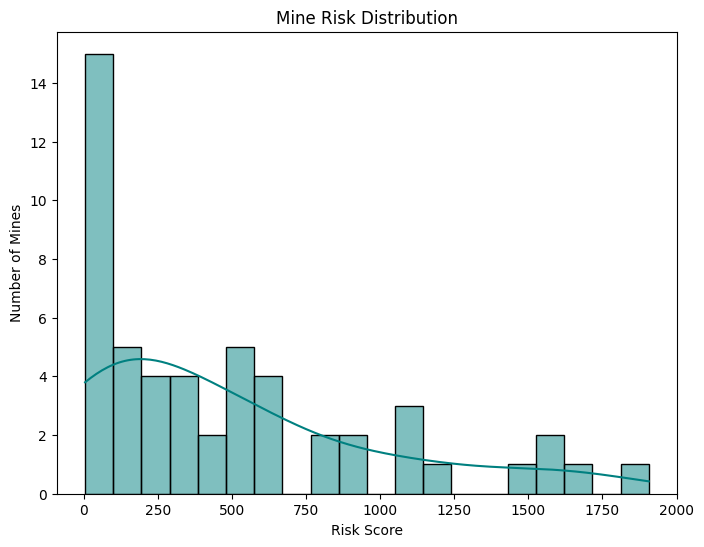

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with a 'Risk' column
plt.figure(figsize=(8, 6))
sns.histplot(df['Risk'], bins=20, kde=True, color='teal')
plt.title('Mine Risk Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Number of Mines')
plt.show()

/tmp/ipython-input-22-2449897847.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




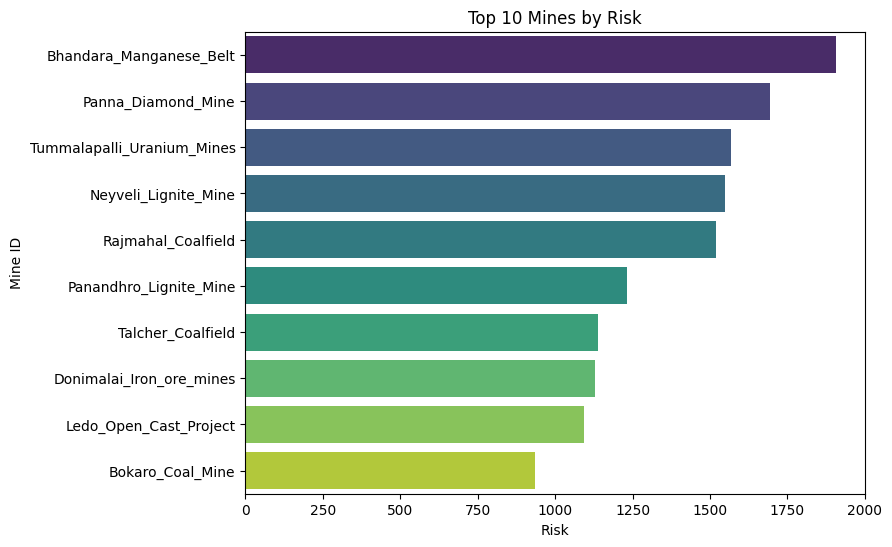

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Top 10 mines by risk score
top_mines = df.sort_values('Risk', ascending=False).head(10)
plt.figure(figsize=(8, 6))
sns.barplot(x='Risk', y='Zone', data=top_mines, palette='viridis')
plt.title('Top 10 Mines by Risk')
plt.xlabel('Risk')
plt.ylabel('Mine ID')
plt.show()


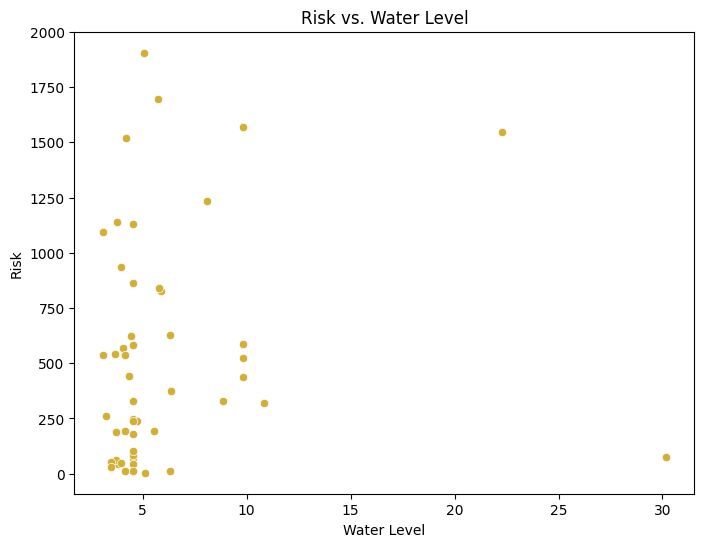

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x='WaterLevel_Mean', y='Risk', data=df, color='#D4AF37')
plt.title('Risk vs. Water Level')
plt.xlabel('Water Level')
plt.ylabel('Risk')
plt.show()